# Marine Debris Detection

## Before you start

### Requirements

In order to run the example you’ll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription?param_domain_id=1&param_redirect_uri=https://apps.sentinel-hub.com/dashboard/oauthCallback.html&param_state=%2F&param_scope=&param_client_id=30cf1d69-af7e-4f3a-997d-0643d660a478&domainId=1). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).


Once you have the account set up, please configure the ```sentinelhub``` package’s configuration file following the [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). For Processing API request you need to obtain and set your ```oauth``` client id and secret.

In [1]:
# from sentinelhub import SHConfig

# config = SHConfig()

# config.instance_id = '<your instance id>'
# config.sh_client_id = '<your client id>'
# config.sh_client_secret = '<your client secret>'

# config.save()

### Overview

### Part 1:

In [1]:
import geopandas as gp
import pandas as pd

import datetime
import os
from glob import glob
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import rasterio
from aenum import MultiValueEnum
from matplotlib.colors import ListedColormap, BoundaryNorm
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from eolearn.core import (
    EOTask,
    EOPatch,
    EOWorkflow,
    linearly_connect_tasks,
    FeatureType,
    OverwritePermission,
    LoadTask,
    SaveTask,
    EOExecutor,
    MergeFeatureTask,
)

from sentinelhub import BBox

from eolearn.core.constants import OverwritePermission

from eolearn.io import SentinelHubInputTask, ImportFromTiffTask, ExportToTiffTask
from eolearn.features import NormalizedDifferenceIndexTask
from eolearn.core import FeatureType

from sentinelhub import DataCollection

## Part 1

In [2]:
# patches = glob(os.path.join('data/patches', '*/*.tif'))
# patches = [p for p in patches if ('_cl.tif' not in p) and ('_conf.tif' not in p)]

# for file in patches:
#     os.remove(file)

In [3]:
DATA_FOLDER = os.path.join(".", "data")
EOPATCH_FOLDER = os.path.join(".", "eopatches")
RESULTS_FOLDER = os.path.join(".", "results")
for folder in (EOPATCH_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

### Define a custom EOTask

In [4]:
# BAND DATA
# Add a request for S2 bands.
band_names = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B10", "B11", "B12"]

In [5]:
class FAI(EOTask):
    """
    """   
    
    @staticmethod
    def FAI(NIR,RED,SWIR):
        l_nir = 833.0
        l_red = 665.0
        l_swir = 1374.0
        factor = 10 * (l_nir - l_red) / (l_swir - l_red)
        
        return NIR - ( RED + ( SWIR - RED ) * factor)
    
    def __init__(self, feature_type, feature_name):
        self.type = feature_type
        self.name = feature_name
        
    def execute(self,
                eopatch,
                band_layer='BANDS', 
                band_names=band_names
                ):
        bands  = eopatch.data[band_layer]

        NIR = bands[:,:,:,band_names.index('B08')]
        RED  = bands[:,:,:,band_names.index('B04')]
        SWIR = bands[:,:,:,band_names.index('B10')]
        
        eopatch[self.type, self.name] = self.FAI(NIR,RED,SWIR).reshape([bands.shape[0], bands.shape[1], bands.shape[2], 1])        
        return eopatch

In [6]:
class FDI(EOTask):
    """
    """   
    
    @staticmethod
    def FDI(NIR,RE2,SWIR1):
        l_nir = 833.0
        l_red = 665.0
        l_swir1 = 1614.0
        factor = 10 * (l_nir - l_red) / (l_swir1 - l_red)
        
        return NIR - ( RE2 + ( SWIR1 - RE2 ) * factor)
    
    def __init__(self, feature_type, feature_name):
        self.type = feature_type
        self.name = feature_name
        
    def execute(self,
                eopatch,
                band_layer='BANDS', 
                band_names=band_names
                ):
        bands  = eopatch.data[band_layer]

        NIR = bands[:,:,:,band_names.index('B08')]
        RE2  = bands[:,:,:,band_names.index('B06')]
        SWIR1 = bands[:,:,:,band_names.index('B11')]
        
        eopatch[self.type, self.name] = self.FDI(NIR,RE2,SWIR1).reshape([bands.shape[0], bands.shape[1], bands.shape[2], 1])        
        return eopatch

Sentinel-2 spectral [bands](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands):

| Band | Wavelenght | Description       |
|------|------------|-------------------|
| B1   | 442.7nm    | Coastal Aerosol   |
| B2   | 492.4nm    | Blue              |
| B3   | 559.8nm    | Green             |
| B4   | 664.6nm    | Red               |
| B5   | 704.1nm    | VNIR Red Edge 1   |
| B6   | 740.5nm    | VNIR Red Edge 2   |
| B7   | 782.8nm    | VNIR Red Edge 3   |
| B8   | 832.8nm    | NIR               |
| B8A  | 864.7nm    | Narrow NIR        |
| B9   | 945.1nm    | SWIR Water Vapour |
| B10  | 1373.5nm   | SWIR Cirrus       |
| B11  | 1613.7nm   | SWIR1             |
| B12  | 2202.4nm   | SWIR2             |

The Level-2A processing includes a scene classification and an atmospheric correction applied to Top-Of-Atmosphere (TOA) Level-1C orthoimage products. Level-2A main output is an orthoimage Bottom-Of-Atmosphere (BOA) corrected reflectance product. The cirrus band 10 in Level-2A is omitted, as it does not contain surface information.

### Define the workflow tasks

In [7]:
# band_names = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B11", "B12"]

input_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    max_threads=5,
)

cl_tif = ImportFromTiffTask(
    (FeatureType.LABEL, "CLASS"), '.', image_dtype=np.uint8
)

conf_tif = ImportFromTiffTask(
    (FeatureType.LABEL, "CONF"), '.', image_dtype=np.uint8
)

# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDMI: (B08 - B11)/(B08 + B11)
NDVI = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)

NDWI = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)

# ndbi = NormalizedDifferenceIndexTask(
#     (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
# )

NDMI = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDMI"), [band_names.index("B08"), band_names.index("B11")]

)

fai = FAI(FeatureType.DATA, "FAI")

fdi = FDI(FeatureType.DATA, "FDI")

# SAVING TO OUTPUT
save = SaveTask(path=EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Reference map task

The labels represent the following 15 classes:

- id = 1, name = Marine Debris
- id = 2, name = Dense Sargassum
- id = 3, name = Sparse Sargassum
- id = 4, name = Natural Organic Material
- id = 5, name = Ship
- id = 6, name = Clouds
- id = 7, name = Marine Water
- id = 8, name = Sediment-Laden Water
- id = 9, name = Foam
- id = 10, name = Turbid Water
- id = 11, name = Shallow Water
- id = 12, name = Waves
- id = 13, name = Cloud Shadows
- id = 14, name = Wakes
- id = 15, name = Mixed Water

We have defined a marine debris enm class for ease of use below.

In [8]:
class MDC(MultiValueEnum):
    """Enum class containing basic marine debris types"""

    NO_DATA = "No Data", 0, "#ffffff"
    MARINE_DEBRIS = "Marine Debris", 1, "#ff0000"
    DENSE_SARGASSUM = "Dense Sargassum", 2, "#008000"
    SPARSE_SARGASSUM = "Sparse Sargassum", 3, "#32cd32"
    NATURAL_ORGANIC_MATERIAL = "Natural Organic Material", 4, "#a52a2a"
    SHIP = "Ship", 5, "#ffa500"
    CLOUDS = "Clouds", 6, "#c0c0c0"
    MARINE_WATER = "Marine Water", 7, "#000080"
    SEDIMENT_LADEN_WATER = "Sediment-Laden Water", 8, "#ffd700"
    FOAM = "Foam", 9, "#800080"
    TURBID_WATER = "Turbid Water", 10, "#bdb76b"
    SHALLOW_WATER = "Shallow Water", 11, "#00ced1"
    WAVES = "Waves", 12, "#fff5ee"
    CLOUD_SHADOWS = "Cloud Shadows", 13, "#808080"
    WAKES = "Wakes", 14, "#ffff00"
    MIXED_WATER = "Mixed Water", 15, "#bc8f8f"
    
    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
mdc_cmap = ListedColormap([x.color for x in MDC], name="mdc_cmap")
mdc_norm = BoundaryNorm([x - 0.5 for x in range(len(MDC) + 1)], mdc_cmap.N)

In [9]:
class Conf_map(MultiValueEnum):
    """Enum class containing confidence mapping types"""
    
    NO_DATA = "No Data", 0, "#ffffff"
    HIGH = "High", 1, "#ff0000"
    MODERATE = "Moderate", 2, "#ffff00"
    LOW = "Low", 3, "#008000"

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
conf_cmap = ListedColormap([x.color for x in Conf_map], name="conf_cmap")
conf_norm = BoundaryNorm([x - 0.5 for x in range(len(Conf_map) + 1)], conf_cmap.N)

### Define the workflow

An EOWorkflow can be linear or more complex, but it should be acyclic. Here we will use the linear case of the EOWorkflow, available as ```LinearWorkflow```.

Define the workflow

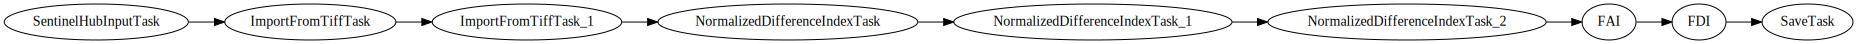

In [10]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    input_task, cl_tif, conf_tif, NDVI, NDWI, NDMI, fai, fdi, save
)

workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

In [11]:
# Define additional parameters of the workflow
input_node = workflow_nodes[0]
cl_node = workflow_nodes[1]
conf_node = workflow_nodes[2]
save_node = workflow_nodes[-1]
execution_args = []

patches = list(zip(glob(os.path.join('data/patches', '*/*cl.tif')), glob(os.path.join('data/patches', '*/*conf.tif'))))

for patch in patches:
    date_time = pd.to_datetime(os.path.basename(patch[0]).split('_')[1], format='%d-%m-%y')
    date_start = date_time - datetime.timedelta(days=1)
    date_end = date_time + datetime.timedelta(days=1)
    index = os.path.basename(patch[0]).split('_cl')[0]
    with rasterio.open(patch[0], 'r') as cl_tiff:
        bounds = cl_tiff.bounds
        crs = cl_tiff.crs
    execution_args.append({
        input_node: {
            'bbox':BBox(bounds,crs=f'{crs}'),
            'time_interval': [date_start, date_end]
        },
        cl_node: {'filename': patch[0]},
        conf_node: {'filename': patch[1]},
        save_node : {"eopatch_folder": f"eopatch_{index}"}
    })

This procedure may take approximately ~55 minutes.

In [12]:
# %%time

# # Execute the workflow
# executor = EOExecutor(workflow, execution_args, save_logs=True)
# executor.run(workers=1)

# executor.make_report()

# failed_ids = executor.get_failed_executions()
# if failed_ids:
#     raise RuntimeError(
#         f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
#         f"For more info check report at {executor.get_report_path()}"
#     )

### Visualize the patches

Let's load a single EOPatch and look at the structure. By executing

In [13]:
eopatch = EOPatch.load(os.path.join(EOPATCH_FOLDER, 'eopatch_S2_1-12-19_48MYU_0'))

We obtain the following structure:

In [14]:
eopatch

EOPatch(
  data={
    BANDS: numpy.ndarray(shape=(1, 256, 256, 11), dtype=float32)
    FAI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
    FDI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
    NDMI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
  }
  label={
    CLASS: numpy.ndarray(shape=(1, 65536), dtype=uint8)
    CONF: numpy.ndarray(shape=(1, 65536), dtype=uint8)
  }
  meta_info={
    maxcc: 0.8
    size_x: 256
    size_y: 256
    time_difference: 7200.0
    time_interval: ['2019-11-30T00:00:00', '2019-12-02T00:00:00']
  }
  bbox=BBox(((706740.0, 9338400.0), (709300.0, 9340960.0)), crs=CRS('32748'))
  timestamp=[datetime.datetime(2019, 12, 1, 3, 19, 39)]
)

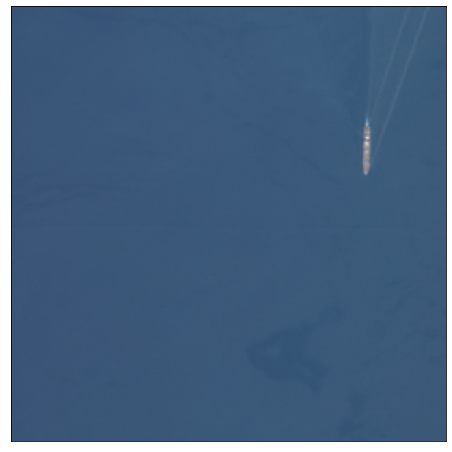

In [15]:
# Draw the RGB image
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("auto")

plt.imshow(np.clip(eopatch.data['BANDS'][0][..., [2,1,0]] * 3.5, 0, 1))
plt.show()

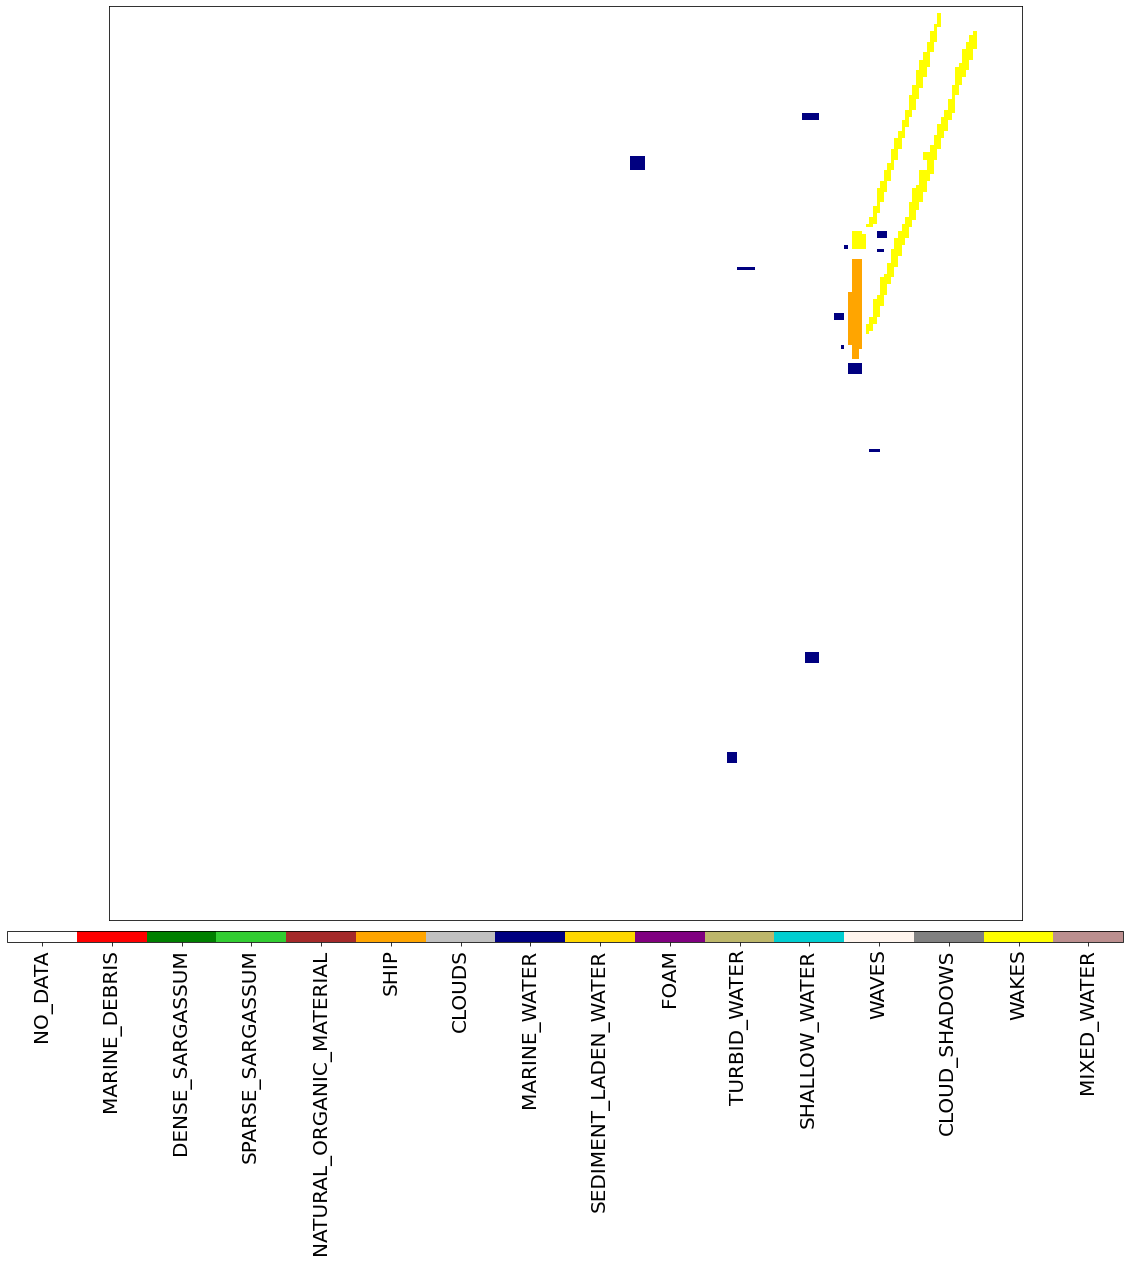

In [16]:
# Visualize the reference map
fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("auto")

im = ax.imshow(np.reshape(eopatch.label['CLASS'], (256, 256)), cmap=mdc_cmap, norm=mdc_norm)
cb = fig.colorbar(im, orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in MDC])
cb.ax.set_xticklabels([entry.name for entry in MDC], rotation=90)
plt.show()

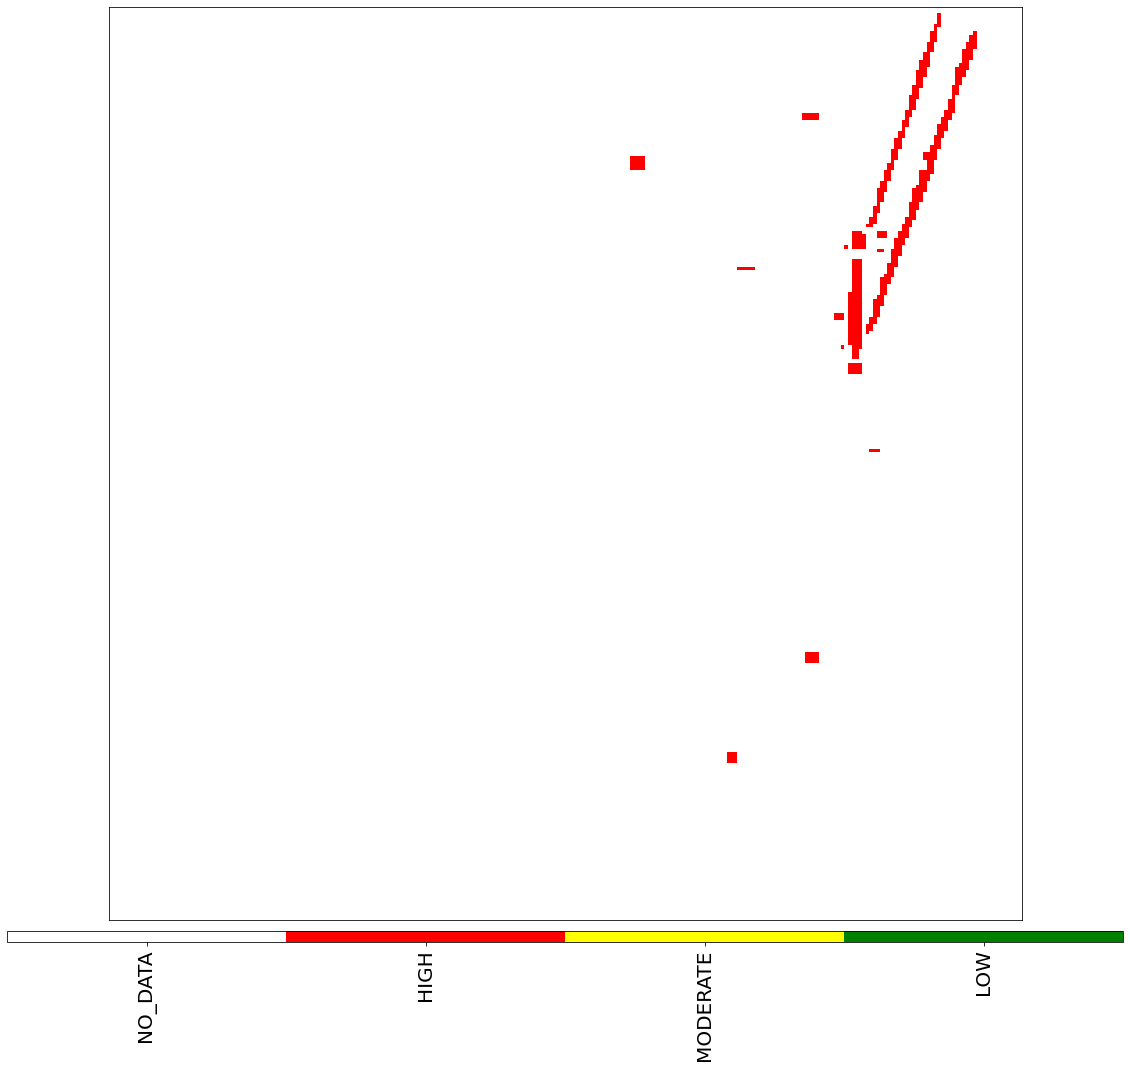

In [17]:
# Visualize the confidence map
fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("auto")

im = ax.imshow(np.reshape(eopatch.label['CONF'], (256, 256)), cmap=conf_cmap, norm=conf_norm)
cb = fig.colorbar(im, orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in Conf_map])
cb.ax.set_xticklabels([entry.name for entry in Conf_map], rotation=90)
plt.show()

### Compute texture features

In [18]:
# GLCM properties
def glcm_feature(matrix_coocurrence):
    contrast = graycoprops(matrix_coocurrence, 'contrast')
    dissimilarity = graycoprops(matrix_coocurrence, 'dissimilarity')
    homogeneity = graycoprops(matrix_coocurrence, 'homogeneity')
    energy = graycoprops(matrix_coocurrence, 'energy')
    correlation = graycoprops(matrix_coocurrence, 'correlation')
    asm = graycoprops(matrix_coocurrence, 'ASM')
    
    return contrast.item(), dissimilarity.item(), homogeneity.item(), energy.item(), correlation.item(), asm.item()

In [68]:
window_size = 13
max_value = 16
paths = glob(os.path.join(EOPATCH_FOLDER, '*'))
columns = ['CON', 'DIS', 'HOMO', 'ENER', 'COR', 'ASM']
texture_df = pd.DataFrame(columns = columns)

for path in tqdm(paths):
    eopatch = EOPatch.load(path, lazy_loading=True)
    features = eopatch.data["BANDS"]
    t, w1, h, f = features.shape
    if t != 0:
        image = np.clip(features[0][..., [2,1,0]] * 3.5, 0, 1)
        gray = rgb2gray(image)

        bins = np.linspace(0.00, 1.00,max_value)
        num_levels = max_value+1
        temp_gray = np.pad(gray, (window_size-1)//2, mode='reflect')

        # get list of coordinates of non zero pixel
        list_pixel = np.argwhere(np.reshape(eopatch.label['CLASS'], (256, 256)) > 0) + ((window_size-1)//2, (window_size-1)//2)

        # get patch for each coordinates and compute GLCM on patches
        res = []
        for p in list_pixel:
            temp_gray_window = temp_gray[p[0] - (window_size -1)//2: p[0] + (window_size -1)//2 + 1, 
                                     p[1] - (window_size -1)//2: p[1] + (window_size -1)//2 + 1]
            inds = np.digitize(temp_gray_window, bins)
            # Calculate on E, NE, N, NW as well as symmetric. So calculation on all directions and with 1 pixel offset-distance
            matrix_coocurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=num_levels, normed=True, symmetric=True)
            # Aggregate all directions
            matrix_coocurrence = matrix_coocurrence.mean(3)[:,:,:,np.newaxis]
            con, dis, homo, ener, cor, asm = glcm_feature(matrix_coocurrence)
            res.append((con, dis, homo, ener, cor, asm))

        res = np.asarray(res, dtype=np.float32)
        texture_df = pd.concat([texture_df, pd.DataFrame(res, columns=columns)])

texture_df.reset_index(drop=True, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1381/1381 [07:04<00:00,  3.26it/s]


## Part 2

### Prepare the trainig data

In [101]:
columns = band_names + ['FAI', 'FDI', 'NDMI', 'NDVI', 'NDWI'] + ['Class', 'Confidence', 'Date', 'Tile', 'Image']
df = pd.DataFrame(columns = columns)
paths = glob(os.path.join(EOPATCH_FOLDER, '*'))
no_data = {}

for path in tqdm(paths):
    eopatch = EOPatch.load(path, lazy_loading=True)
    name = path.split('eopatch_')[1]
    date = name.split('_')[1]
    tile = name.split('_')[2]
    image = name.split('_')[3]
    
    features = eopatch.data["BANDS"]
    
    FAI = eopatch.data['FAI']
    FDI = eopatch.data['FDI']
    NDMI = eopatch.data['NDMI']
    NDVI = eopatch.data['NDVI']
    NDWI = eopatch.data['NDWI']

    CLASS = eopatch.label['CLASS']
    CONF = eopatch.label['CONF']
    
    t, w1, h, f = features.shape
    if t == 0:
        splitted = name.split('_')
        index = splitted[1] + '_' + splitted[2]
        if index in no_data:
            no_data[index].append(name)
        else:
            no_data[index] = []
            no_data[index].append(name)
    else:
        features = np.moveaxis(features, 0, 2).reshape(w1 * h, t * f)
        t, w1, h, f = FAI.shape
        FAI = np.moveaxis(FAI, 0, 2).reshape(w1 * h, t * f)
        FDI = np.moveaxis(FDI, 0, 2).reshape(w1 * h, t * f)
        NDMI = np.moveaxis(NDMI, 0, 2).reshape(w1 * h, t * f)
        NDVI = np.moveaxis(NDVI, 0, 2).reshape(w1 * h, t * f)
        NDWI = np.moveaxis(NDWI, 0, 2).reshape(w1 * h, t * f)
        features = np.concatenate((features, FAI, FDI, NDMI, NDVI, NDWI), axis=1)

        filter_class = np.squeeze(CLASS) > 0
        filter_conf = np.squeeze(CONF) > 0

        fcl_features = features[filter_class]
        fcn_features = features[filter_conf]

        if fcl_features.shape != fcn_features.shape:
            print("Error filtering class is different from filtering conf")

        column_date = np.full((fcl_features.shape[0], 1), date)
        column_tile = np.full((fcl_features.shape[0], 1), tile)
        column_image = np.full((fcl_features.shape[0], 1), image)
        data = np.concatenate((fcl_features, CLASS.T[filter_class], CONF.T[filter_conf], column_date, column_tile, column_image), axis=1)
        df = pd.concat([df, pd.DataFrame(data, columns=columns)])

df.reset_index(drop=True, inplace=True)
df[df.columns[:-5]] = df[df.columns[:-5]].astype(np.float32)
tot_data = pd.concat([df, texture_df], axis=1)
cols = tot_data.columns.tolist()
new_cols = cols[:16] + cols[21:] + cols[16:21]
df = tot_data[new_cols]

csv = os.path.join(DATA_FOLDER, 'df.csv')
df.to_csv(csv, index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1381/1381 [06:10<00:00,  3.73it/s]


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803550 entries, 0 to 803549
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   B02         803550 non-null  float32
 1   B03         803550 non-null  float32
 2   B04         803550 non-null  float32
 3   B05         803550 non-null  float32
 4   B06         803550 non-null  float32
 5   B07         803550 non-null  float32
 6   B08         803550 non-null  float32
 7   B09         803550 non-null  float32
 8   B10         803550 non-null  float32
 9   B11         803550 non-null  float32
 10  B12         803550 non-null  float32
 11  FAI         803550 non-null  float32
 12  FDI         803550 non-null  float32
 13  NDMI        803524 non-null  float32
 14  NDVI        803524 non-null  float32
 15  NDWI        803524 non-null  float32
 16  CON         803550 non-null  float32
 17  DIS         803550 non-null  float32
 18  HOMO        803550 non-null  float32
 19  EN

In [103]:
df.describe()

,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,...,FDI,NDMI,NDVI,NDWI,CON,DIS,HOMO,ENER,COR,ASM
count,803550.000000,803550.000000,803550.000000,803550.000000,803550.000000,803550.000000,803550.000000,803550.000000,803550.000000,803550.000000,...,803550.000000,803524.000000,803524.000000,803524.000000,803550.000000,803550.000000,803550.000000,803550.000000,803550.000000,803550.000000
mean,0.120992,0.108809,0.101144,0.090348,0.074456,0.079421,0.065377,0.010288,0.001763,0.020679,...,0.086121,0.586116,-0.264877,0.342182,0.115197,0.087299,0.958670,0.877134,0.716218,0.804607
std,0.042637,0.048721,0.066053,0.065314,0.062384,0.067674,0.061643,0.026352,0.004926,0.053847,...,0.077296,0.288218,0.140688,0.225076,0.367859,0.156541,0.068122,0.187733,0.349222,0.277292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.302441,-0.675633,-0.794066,-0.457551,0.000000,0.000000,0.447041,0.127573,-0.242948,0.016275
25%,0.101100,0.077700,0.046600,0.037000,0.028300,0.027800,0.022000,0.005400,0.000500,0.004200,...,0.024995,0.405660,-0.371925,0.161931,0.000000,0.000000,0.937233,0.783876,0.419142,0.614462
50%,0.119300,0.112200,0.099000,0.090100,0.064700,0.067700,0.053800,0.006300,0.000700,0.008100,...,0.042860,0.655172,-0.282469,0.351521,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,0.131200,0.134700,0.149800,0.137200,0.109000,0.118975,0.094200,0.007900,0.001200,0.016300,...,0.147704,0.848592,-0.160041,0.541225,0.127003,0.125801,1.000000,1.000000,1.000000,1.000000
max,0.804400,0.795100,0.887000,0.890000,0.905400,0.938200,0.946900,0.512000,0.060600,0.917500,...,0.690694,0.982609,0.589513,0.845225,11.786859,2.068643,1.000000,1.000000,1.000000,1.000000
